<a href="https://colab.research.google.com/github/oriwolloffer/airbnbProject/blob/main/Copy_of_Increase_RAM_Reference_Notes_By_Techhawa_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sep 3rd - Project

# 1.Data Preparation
## Introduction

 Airbnb is the leading platform in providing lodging and tourism experience. Inside Airbnb’s business
logic, pricing is probably the most important for hosts and customers. Ensuring fair pricing directly
affects booking activities, and also matters to the well-being of the e-commerce environment. Thus,
studying the reasonable forecast and fair suggestion of prices of Airbnb listings can have huge real-life
values and may generalize to other applications as well.

Unlike hotels, which have their own pricing system, Aribnb prices are usually determined by the hosts empirically. It
poses challenges for the new hosts, as well as for existing hosts with new listings, to determine the prices reasonably high
yet without losing popularity. On the consumers’ side, though they can compare the price across other similar listings,
it is still valuable for them to know whether the current price is worthy and if it is a good time to book the rooms.

In this project, we build a price prediction model of Airbnb listings and make comparisons between
different methods. The input to our algorithm is Berlin Airbnb Open Data which contains continuous / categorical data as well as rich text data (descriptions, reviews) about listings.
We then use traditional ML methods (linear regression, ridge regression, support vector regression,
random forest regression, gradient boosting) and four neural networks to output the predicted prices
of listings.

---Data source Limitations -----
There are some limitations to the data in that I only used listings scraped in September 2019. Furthermore, while I wanted to model seasonality with time series, InsideAirBnB did not have a year’s worth of data for Tokyo.

Something to keep in mind is that modeling prices on all the scraped listings doesn’t make much sense. Many of these listings may be priced poorly or inactive and training a model on them wouldn’t necessarily suggest optimal prices. Therefore, defining what a “good” listing is and filtering out sub-optimal listings was the first step in the data cleaning process. One key feature to keep track of was occupancy, which wasn’t a feature included in the dataset.

### Importing the libraries and data

In [1]:
#import pyodbc
from sqlalchemy import create_engine
import pandas as pd
import re
import numpy as np
from datetime import datetime
from geopy import distance
from geopy.distance import great_circle
from datetime import date
from sklearn.utils import shuffle
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import linear_model
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import math
#from sqlalchemy import create_engine

from google.colab import drive
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)


%matplotlib inline
#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
#import math

#from google.colab import files
#uploaded = files.upload()


In [2]:

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
path = '/content/gdrive/MyDrive/AirBnb/df.csv'
df = pd.read_csv(path)

In [4]:
df.head()
#booleans=['', '','','', '', '','', '',  '', '']


,id,host_since,first_review,last_review,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_name,host_about,security_deposit,cleaning_fee,extra_people,price,host_listings_count,host_total_listings_count,latitude,longitude,amenities,host_verifications,host_acceptance_rate,host_response_rate,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_id,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,bed_type,has_availability,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calendar_updated
0,13011494,2012-12-11,2017-07-18,2018-07-25,Bright and spacious room wth balcony and roof ...,The apartment is located in Neukölln (Kreuzköl...,"The 60sqm, two-bedroom flat offers space for m...",The apartment is located in Neukölln (Kreuzköl...,"-Shops, restaurants, bars, clubs, galleries, t...",Please notice! There is no elevator. During yo...,-Free parking on the streets -U-Bahn stations ...,Access to shared kitchen and bathroom.,"Since I wont be at home myself, the communicat...","-Feel like home, but respect the home and poss...",Svenja,"Hello!\r\n\r\nI am a dance teacher, a travelli...",$250.00,$20.00,$10.00,$40.00,2.0,2.0,52.492309,13.427217,"{Wifi,Kitchen,""Free street parking"",""Buzzer/wi...","['email', 'phone', 'reviews']",NaN,NaN,1,1.0,1.0,1.0,NaN,1,4,30,0,0,0,0,8,100.0,10.0,10.0,10.0,10.0,9.0,10.0,2,0.50,4379053,"Berlin, Berlin, Germany",NaN,f,NaN,t,f,Neukölln,Reuterstraße,Neukölln,12047,f,Apartment,Private room,Real Bed,t,t,f,f,moderate,f,f,4 months ago
1,13012064,2016-05-13,2016-05-14,2016-05-14,Yachtclub,Zimmer im Boot im Hof,NaN,Zimmer im Boot im Hof,NaN,NaN,NaN,NaN,NaN,NaN,Tiphaine,NaN,NaN,NaN,$0.00,$98.00,1.0,1.0,52.540207,13.419285,"{Wifi,Kitchen,Washer,Essentials,""translation m...","['email', 'phone', 'reviews']",NaN,NaN,2,1.0,1.0,1.0,NaN,1,1,1125,0,0,0,0,1,100.0,10.0,8.0,10.0,10.0,10.0,10.0,1,0.03,71794597,DE,NaN,f,Prenzlauer Berg,t,f,Prenzlauer Berg,Helmholtzplatz,Pankow,10435,t,Boat,Shared room,Real Bed,t,t,f,f,flexible,f,f,30 months ago
2,13013132,2016-05-13,2016-06-07,2018-09-16,eastside,Meine Unterkunft ist in der Nähe von Nachtlebe...,NaN,Meine Unterkunft ist in der Nähe von Nachtlebe...,NaN,NaN,NaN,NaN,NaN,NaN,Martin,NaN,NaN,$25.00,$20.00,$45.00,1.0,1.0,52.534344,13.551447,"{TV,Wifi,Kitchen,""Free parking on premises"",""S...","['email', 'phone', 'facebook', 'reviews']",NaN,88%,3,1.0,1.0,1.0,NaN,1,1,14,28,58,88,363,6,100.0,10.0,9.0,10.0,10.0,9.0,8.0,1,0.20,71804196,"Berlin, Berlin, Germany",within a day,f,Marzahn,t,f,Marzahn,Marzahn-Süd,Marzahn - Hellersdorf,12685,t,Apartment,Private room,Real Bed,t,t,f,f,strict_14_with_grace_period,f,f,4 weeks ago
3,13013744,2012-01-24,2016-05-16,2016-05-16,Cosy Room with sunny Balcony,The room is in a two-room apartment in the mid...,NaN,The room is in a two-room apartment in the mid...,NaN,NaN,NaN,NaN,NaN,NaN,Jannis,"Hey there,\r\n\r\nI'm Jannis from Berlin. Fina...",NaN,NaN,$5.00,$25.00,1.0,1.0,52.476278,13.435592,"{Internet,Wifi,Kitchen,Heating,Washer,Essentia...","['email', 'phone', 'reviews', 'jumio', 'govern...",NaN,NaN,2,1.0,1.0,1.0,NaN,1,1,1125,0,0,0,0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.03,1647574,"Berlin, Berlin, Germany",NaN,f,Neukölln,t,t,Neukölln,Neuköllner Mitte/Zentrum,Neukölln,12053,t,Apartment,Private room,Real Bed,t,t,f,f,flexible,f,f,30 months ago
4,13017018,2014-10-27,2016-05-23,2018-09-21,Large and Cosy

In [5]:
df.dtypes

id                                    int64
host_since                           object
first_review                         object
last_review                          object
name                                 object
summary                              object
space                                object
description                          object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
host_name                            object
host_about                           object
security_deposit                     object
cleaning_fee                         object
extra_people                         object
price                                object
host_listings_count                 float64
host_total_listings_count           float64
latitude                        

# 2.Exploratory Data Analysis (EDA)


## pre-processing the data

initial columns to work with (by dtype)

In [6]:
features = ['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 
      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'square_feet',     
      'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 
      'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
      'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']

one_hot_col_names = ['host_id',  'host_location', 'host_response_time','host_is_superhost','host_neighbourhood','host_has_profile_pic','host_identity_verified',
           'neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed', 'zipcode', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'instant_bookable', 
           'is_business_travel_ready',  'cancellation_policy','require_guest_profile_picture', 'require_guest_phone_verification', 'calendar_updated']
text_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_name', 'host_about']
date_cols = ['host_since', 'first_review', 'last_review']
price_features = ['security_deposit', 'cleaning_fee', 'extra_people','price']

#-----------------------
#object_to_numbers=['host_listings_count','host_response_rate', 'host_total_listings_count','accommodates','bedrooms', 'beds', 'square_feet','guests_included', 'minimum_nights',  'availability_30', 'availability_60', 
   #  'availability_90', 'availability_365','number_of_reviews','calculated_host_listings_count' ]

booleans=['host_is_superhost', 'host_has_profile_pic','host_identity_verified','is_location_exact', 'has_availability', 'requires_license','instant_bookable', 'is_business_travel_ready',  'require_guest_profile_picture', 'require_guest_phone_verification']
# all features = features + one_hot_col_names + text_cols + date_cols + price_features
lists = [features , one_hot_col_names , text_cols , date_cols , price_features]
# not in list = ['amenities', 'host_acceptance_rate', 'host_response_rate']

### functions

In [7]:
def obj_to_num(to_numbers):
    
#    df['host_id'] = df['host_id'].astype(str)
    for i in range(len(to_numbers)):
        if to_numbers[i] in df.columns:
            
            df[to_numbers[i]] = df[to_numbers[i]].astype('float64',errors='ignore')
#    for j in range(len(to_one_hot)):
 #       df[to_one_hot[j]].replace({'f': 0, 't': 1}, inplace=True)

In [8]:
def booleans_to_numbers(s):
    if s == 'f':
        return int(0)
    elif s == 't':
        return int(1)
    return None
    

In [9]:
def update_columns(drop_list):
#    lists = [features , one_hot_col_names , text_cols , date_cols , price_features]
    for list in lists:
        for f in list:
            if f in drop_list:
                list.remove(f)
    df.drop(columns = drop_list, inplace=True)

In [10]:
def price_clean(arr):
    for i in arr:
        df[i].fillna('$0.00', inplace=True)
        df[i] = df[i].str.replace('$', '').str.replace(',', '').astype(float)
        df[i] = df[i].astype('int64')


In [11]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [12]:
df.shape

(22552, 73)

###dropping Unnecessary columns

In [13]:
#text columns will be dropped for now, as will other columns which are not useful for predicting price
df = df.drop(text_cols, axis=1)

In [14]:
#removing columns with to many null values
df.isna().sum().sort_values(ascending =False)
df.drop(['host_acceptance_rate','square_feet'], axis=1, inplace=True)


In [15]:
#removing columns with the same data. i keep the column bc no nulls: *calculated_host_listings_count*
df.drop(['host_total_listings_count', 'host_listings_count'], axis=1, inplace=True)

In [16]:
# data types conversion
#obj_to_num(object_to_numbers)

for col in booleans:
#    print(col)
    df[col] = df[col].apply(booleans_to_numbers)


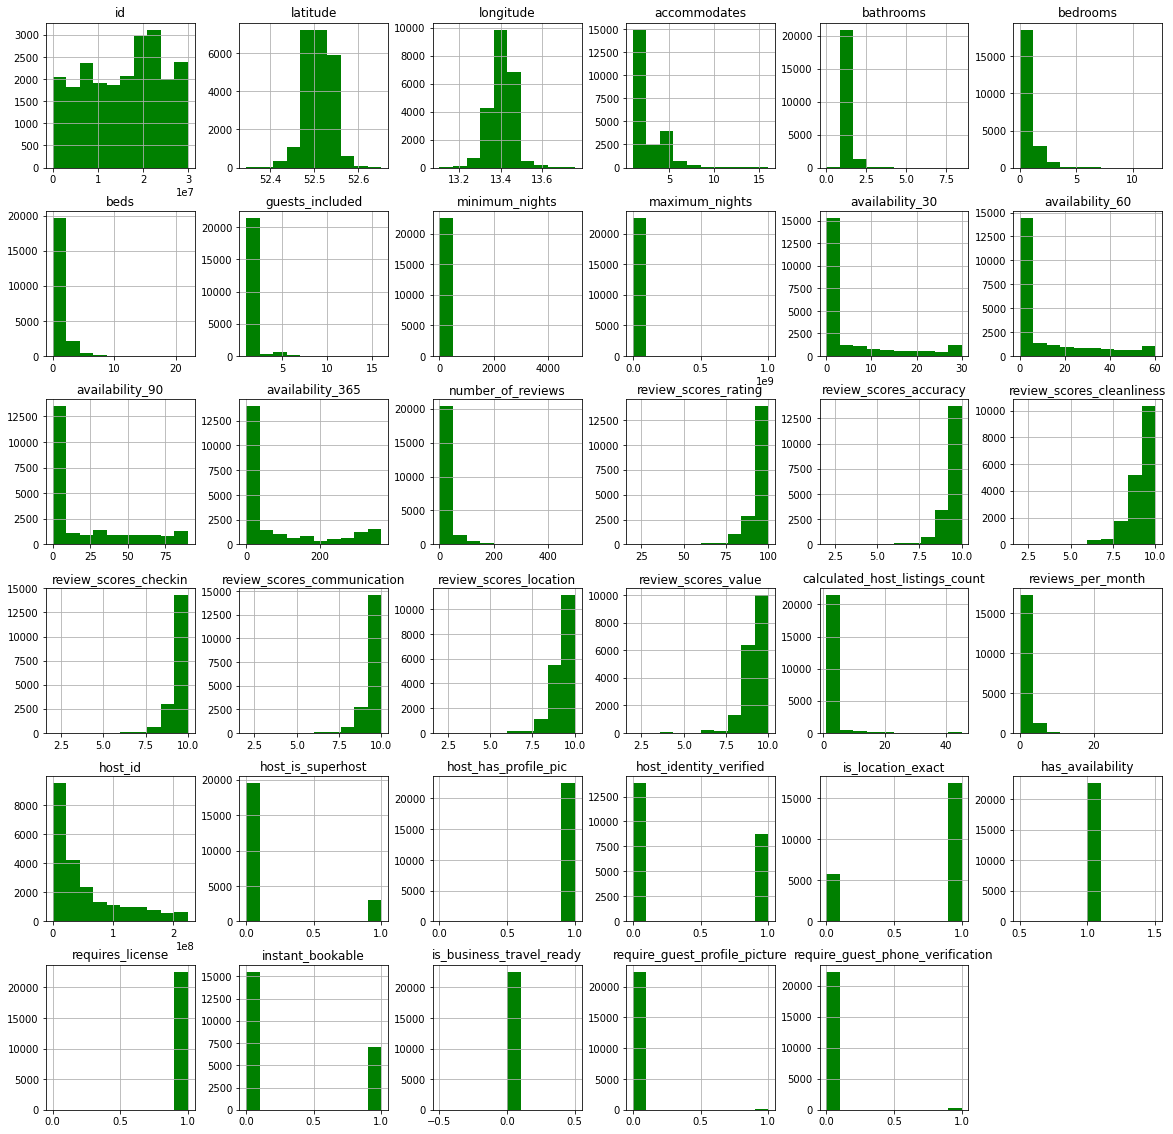

In [17]:
#Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:
df.hist(figsize=(20,20),color ='g' );

In [18]:
#the following columns has discrete value for all the dataset, and therefor will be drop  
colls_to_drop1=['has_availability','host_id','requires_license','is_business_travel_ready','require_guest_phone_verification','require_guest_profile_picture','host_has_profile_pic']
df.drop(colls_to_drop1, axis=1, inplace=True)
df.drop(['host_response_rate','zipcode','host_neighbourhood','neighbourhood','host_location'], axis=1, inplace=True)


In [19]:
df.shape

(22552, 45)

In [20]:
df.isnull().sum()

id                                    0
host_since                           26
first_review                       3914
last_review                        3908
security_deposit                   9361
cleaning_fee                       7146
extra_people                          0
price                                 0
latitude                              0
longitude                             0
amenities                             0
host_verifications                    0
accommodates                          0
bathrooms                            32
bedrooms                             18
beds                                 40
guests_included                       0
minimum_nights                        0
maximum_nights                        0
availability_30                       0
availability_60                       0
availability_90                       0
availability_365                      0
number_of_reviews                     0
review_scores_rating               4389


### cleaning other columns

is_location_exact

In [21]:
df.is_location_exact.value_counts(normalize=True,dropna=False)

1    0.743881
0    0.256119
Name: is_location_exact, dtype: float64

host_identity_verified

In [22]:
df.host_identity_verified.value_counts(dropna=False)

0.0    13824
1.0     8702
NaN       26
Name: host_identity_verified, dtype: int64

instant_bookable

In [23]:
df.instant_bookable.value_counts(normalize=True,dropna=False)

0    0.688099
1    0.311901
Name: instant_bookable, dtype: float64

host_response_time

In [24]:
df.host_response_time.value_counts(normalize=True,dropna=False)

NaN                   0.571745
within an hour        0.225302
within a few hours    0.094315
within a day          0.091344
a few days or more    0.017293
Name: host_response_time, dtype: float64

In [25]:
df.host_response_time.fillna("unknown", inplace=True)
#df.host_response_time.replace({ 'N/A': 'unknown'}, inplace=True)
df.host_response_time.value_counts(normalize=True,dropna=False)

unknown               0.571745
within an hour        0.225302
within a few hours    0.094315
within a day          0.091344
a few days or more    0.017293
Name: host_response_time, dtype: float64

host_is_superhost

In [26]:
df['host_is_superhost'].value_counts(dropna=False)

0.0    19515
1.0     3011
NaN       26
Name: host_is_superhost, dtype: int64

In [27]:
#df.host_is_superhost.fillna(0, inplace=True)

room_type

In [28]:
df['room_type'].value_counts(normalize=True,dropna=False)

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

calculated_host_listings_count

In [29]:
df['calculated_host_listings_count'].describe()

count    22552.000000
mean         1.918233
std          3.667257
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         45.000000
Name: calculated_host_listings_count, dtype: float64

In [30]:
df['calculated_host_listings_count'].value_counts(normalize=True,dropna=False)

1     0.764367
2     0.127882
3     0.035651
4     0.014544
5     0.010199
6     0.007183
7     0.006208
9     0.003991
8     0.003902
19    0.003370
12    0.003193
17    0.003015
10    0.002217
45    0.001995
11    0.001951
43    0.001907
16    0.001419
30    0.001330
15    0.001330
14    0.001242
26    0.001153
13    0.001153
18    0.000798
Name: calculated_host_listings_count, dtype: float64

property_type

In [31]:
# property_type 
df['property_type'].value_counts(normalize=True,dropna=False)

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Camper/RV                 0.000488
Houseboat                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Castle                    0.000089
Casa particular (Cuba)    0.000089
Train                     0.000089
Tipi                      0.000044
Chalet              

In [32]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Condominium': 'Apartment',
    'Loft': 'Apartment',
    'House': 'House',
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Aparthotel': 'Apartment',
    'Bungalow' : 'House'
    
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [33]:
df['property_type'].value_counts(normalize=True,dropna=False)

Apartment    0.952421
House        0.024078
Other        0.023501
Name: property_type, dtype: float64

calendar_updated

In [34]:
# calendar_updated ----> NAN can be assumed to be 0
df['calendar_updated'].value_counts(normalize=True,dropna=False)

today            0.111609
2 weeks ago      0.059330
a week ago       0.057245
2 months ago     0.049175
3 weeks ago      0.044918
3 months ago     0.044431
yesterday        0.041992
4 months ago     0.040795
4 weeks ago      0.032636
5 months ago     0.024965
3 days ago       0.023058
8 months ago     0.022393
5 weeks ago      0.021506
2 days ago       0.021462
6 weeks ago      0.020663
6 months ago     0.020530
11 months ago    0.020087
7 months ago     0.019333
5 days ago       0.017471
15 months ago    0.016761
9 months ago     0.016185
10 months ago    0.016140
4 days ago       0.015786
14 months ago    0.014677
12 months ago    0.013258
16 months ago    0.011662
13 months ago    0.011485
7 weeks ago      0.010553
35 months ago    0.009267
18 months ago    0.008868
19 months ago    0.008336
28 months ago    0.008336
27 months ago    0.008292
33 months ago    0.008070
17 months ago    0.007538
21 months ago    0.007494
32 months ago    0.007228
34 months ago    0.006873
20 months ag

In [35]:
# Replacing categories refering to this week (the last 7 days)
df.calendar_updated.replace({
    'yesterday': 'This week',
    'a week ago': 'This week',
    '4 days ago': 'This week',
    '3 days ago': 'This week',
    '5 days ago': 'This week',
    '6 days ago': 'This week',
    '1 week ago': 'This week'
    
    }, inplace=True)

# Replacing rest categories of more than a month
df.loc[~df.calendar_updated.isin(['This week', 'today','2 weeks ago','3 weeks ago','4 weeks ago']), 'calendar_updated'] = 'more then a month ago'

In [36]:
df['calendar_updated'].value_counts(normalize=True,dropna=False)

more then a month ago    0.585314
This week                0.166194
today                    0.111609
2 weeks ago              0.059330
3 weeks ago              0.044918
4 weeks ago              0.032636
Name: calendar_updated, dtype: float64

In [37]:
# one_hot_col_names = ['host_id',  'host_location', 'host_response_time','host_is_superhost','host_neighbourhood','host_has_profile_pic','host_identity_verified',
#          'neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed', 'zipcode', 'is_location_exact', 'property_type', 'room_type', 'bed_type',   'instant_bookable', 
#           'cancellation_policy', 'calendar_updated']

In [38]:
df.shape

(22552, 45)

In [39]:
df_2=df.copy()

In [40]:
df.isna().sum().sort_values(ascending =False)

security_deposit                  9361
cleaning_fee                      7146
review_scores_value               4435
review_scores_checkin             4432
review_scores_location            4431
review_scores_communication       4418
review_scores_accuracy            4414
review_scores_cleanliness         4411
review_scores_rating              4389
reviews_per_month                 3914
first_review                      3914
last_review                       3908
beds                                40
bathrooms                           32
host_identity_verified              26
host_since                          26
host_is_superhost                   26
bedrooms                            18
host_verifications                   0
accommodates                         0
amenities                            0
calendar_updated                     0
guests_included                      0
latitude                             0
price                                0
extra_people             

cancellation_policy

In [41]:
df.cancellation_policy.value_counts()


flexible                       9102
moderate                       7096
strict_14_with_grace_period    6287
super_strict_30                  53
super_strict_60                  14
Name: cancellation_policy, dtype: int64

In [42]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict',
    'super_strict_60': 'strict',
    'strict_14_with_grace_period': 'strict_with_grace_period'
    
    }, inplace=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              22552 non-null  int64  
 1   host_since                      22526 non-null  object 
 2   first_review                    18638 non-null  object 
 3   last_review                     18644 non-null  object 
 4   security_deposit                13191 non-null  object 
 5   cleaning_fee                    15406 non-null  object 
 6   extra_people                    22552 non-null  object 
 7   price                           22552 non-null  object 
 8   latitude                        22552 non-null  float64
 9   longitude                       22552 non-null  float64
 10  amenities                       22552 non-null  object 
 11  host_verifications              22552 non-null  object 
 12  accommodates                    

'accommodates', 'bathrooms', 'bedrooms', 'beds'

In [44]:
# 'accommodates', 'bathrooms', 'bedrooms', 'beds' 
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,22552.0,2.637460,1.510548,1.0,2.0,2.0,3.0,16.0
bathrooms,22520.0,1.092695,0.329894,0.0,1.0,1.0,1.0,8.5
bedrooms,22534.0,1.161134,0.646156,0.0,1.0,1.0,1.0,12.0
beds,22512.0,1.620558,1.174840,0.0,1.0,1.0,2.0,22.0


In [45]:
# listingds with 0 beds are probably mistake, so theyll get the median value 
df.loc[(df['bedrooms'].isnull() | df['bedrooms'] == 0) , ['bed_type','beds','bedrooms']]

,bed_type,beds,bedrooms
35,Real Bed,1.0,0.0
42,Pull-out Sofa,1.0,0.0
82,Real Bed,1.0,0.0
87,Real Bed,3.0,0.0
95,Real Bed,1.0,0.0
...,...,...,...
22435,Real Bed,2.0,0.0
22452,Real Bed,1.0,0.0
22469,Real Bed,2.0,0.0
22483,Real Bed,1.0,0.0


In [46]:
#Nans values will get the median and 0 values will get 1 (the realistic min)
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)
    df[col].replace({0: 1}, inplace=True)
    df[col] = df[col].astype('int64')

In [47]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,22552.0,2.637460,1.510548,1.0,2.0,2.0,3.0,16.0
bathrooms,22552.0,1.064828,0.309719,0.0,1.0,1.0,1.0,8.0
bedrooms,22552.0,1.226499,0.571252,1.0,1.0,1.0,1.0,12.0
beds,22552.0,1.620876,1.172734,1.0,1.0,1.0,2.0,22.0


price

In [48]:
price_clean(price_features)
df[['security_deposit', 'cleaning_fee', 'extra_people','price']].describe().T

,count,mean,std,min,25%,50%,75%,max
security_deposit,22552.0,118.284454,304.232661,0.0,0.0,0.0,150.0,4280.0
cleaning_fee,22552.0,18.253991,28.172816,0.0,0.0,10.0,30.0,2000.0
extra_people,22552.0,8.257716,11.151069,0.0,0.0,5.0,15.0,250.0
price,22552.0,67.143668,220.266210,0.0,30.0,45.0,70.0,9000.0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              22552 non-null  int64  
 1   host_since                      22526 non-null  object 
 2   first_review                    18638 non-null  object 
 3   last_review                     18644 non-null  object 
 4   security_deposit                22552 non-null  int64  
 5   cleaning_fee                    22552 non-null  int64  
 6   extra_people                    22552 non-null  int64  
 7   price                           22552 non-null  int64  
 8   latitude                        22552 non-null  float64
 9   longitude                       22552 non-null  float64
 10  amenities                       22552 non-null  object 
 11  host_verifications              22552 non-null  object 
 12  accommodates                    

host_since

In [50]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2018, 11, 7) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)
df.host_days_active=df.host_days_active.astype('int64')

Mean days as host: 1346.0
Median days as host: 1289.0


In [51]:
df.dropna(subset=['host_since'], inplace=True)


first_review and last_review



In [52]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 17.3%
Null values in 'review_scores_rating': 19.4%


In [53]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2018, 11, 7) - df.first_review).astype('timedelta64[D]')

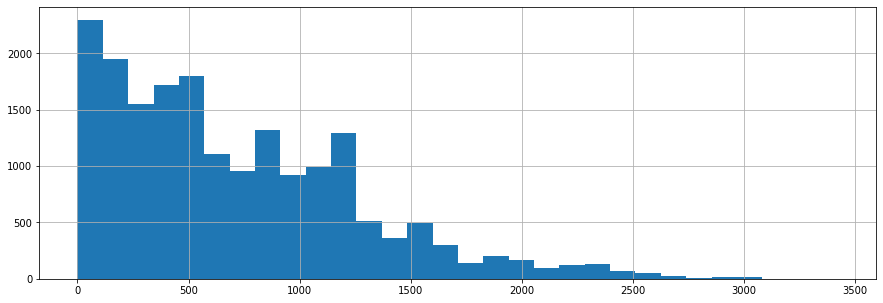

In [54]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [55]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [56]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [57]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2018, 11, 7) - df.last_review).astype('timedelta64[D]')

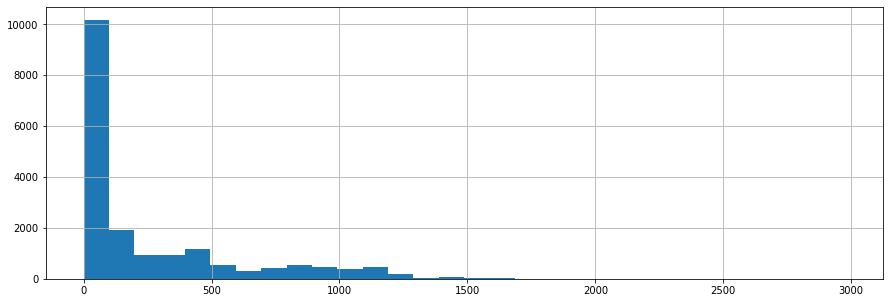

In [58]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [59]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')


In [60]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop(['last_review','first_review'], axis=1, inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 0 to 22551
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              22526 non-null  int64         
 1   host_since                      22526 non-null  datetime64[ns]
 2   security_deposit                22526 non-null  int64         
 3   cleaning_fee                    22526 non-null  int64         
 4   extra_people                    22526 non-null  int64         
 5   price                           22526 non-null  int64         
 6   latitude                        22526 non-null  float64       
 7   longitude                       22526 non-null  float64       
 8   amenities                       22526 non-null  object        
 9   host_verifications              22526 non-null  object        
 10  accommodates                    22526 non-null  int64         
 11  ba

review ratings columns

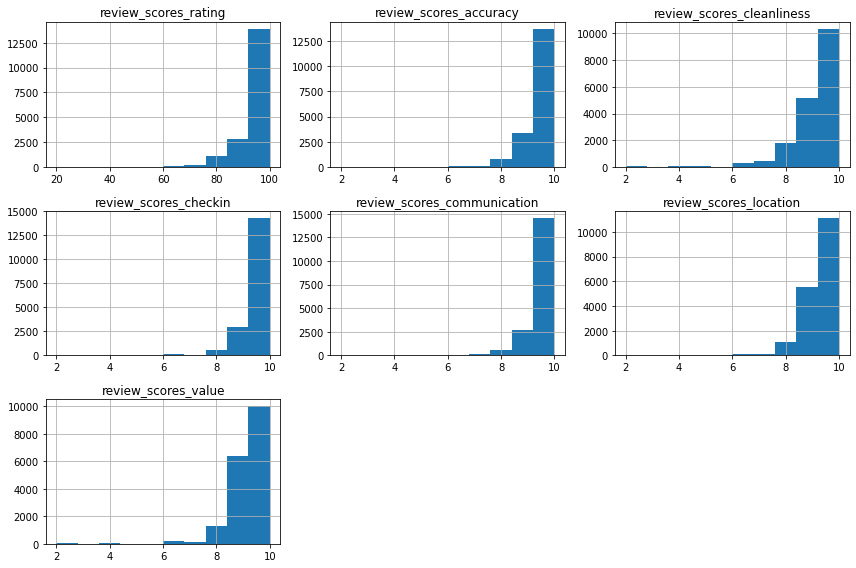

In [62]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 0 to 22551
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              22526 non-null  int64         
 1   host_since                      22526 non-null  datetime64[ns]
 2   security_deposit                22526 non-null  int64         
 3   cleaning_fee                    22526 non-null  int64         
 4   extra_people                    22526 non-null  int64         
 5   price                           22526 non-null  int64         
 6   latitude                        22526 non-null  float64       
 7   longitude                       22526 non-null  float64       
 8   amenities                       22526 non-null  object        
 9   host_verifications              22526 non-null  object        
 10  accommodates                    22526 non-null  int64         
 11  ba

In [64]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [65]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [66]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 0 to 22551
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              22526 non-null  int64         
 1   host_since                      22526 non-null  datetime64[ns]
 2   security_deposit                22526 non-null  int64         
 3   cleaning_fee                    22526 non-null  int64         
 4   extra_people                    22526 non-null  int64         
 5   price                           22526 non-null  int64         
 6   latitude                        22526 non-null  float64       
 7   longitude                       22526 non-null  float64       
 8   amenities                       22526 non-null  object        
 9   host_verifications              22526 non-null  object        
 10  accommodates                    22526 non-null  int64         
 11  ba

# 3.Feature Engineering

## Feature Engineering 1:  **Amenities**



In [68]:
def amenities(cols):
    dic = {}
    i = 0
    for col in cols:
        arr = col.split(',')
        for a in arr:
            ar = re.sub(r'\W+', '', a)
            if len(ar) > 0:
                if ar not in dic:
                    dic[ar] = i
                    i += 1
    
    l = len(dic)
    new_cols = np.zeros((cols.shape[0], l))
    for i, col in enumerate(cols):
        words = col.split(',')
        arr = np.zeros(l)
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '':
                arr[dic[wr]] = 1
        new_cols[i] = arr
    return pd.DataFrame(new_cols,columns=list(dic.keys())).astype('int64')


In [69]:
amenities_df = amenities(df['amenities'])

In [70]:
amenities_plot_df=pd.melt(amenities_df, value_name='count',var_name='amenity',)
amenities_plot_df=amenities_plot_df.groupby('amenity', as_index=True).agg({"count": "sum"}).sort_values(['count'],ascending =False)
amenities_plot_df

,count
amenity,
Wifi,21486
Kitchen,21306
Heating,21167
Essentials,20310
Washer,18473
Hairdryer,14885
Laptopfriendlyworkspace,14440
Hangers,13903
Iron,11203


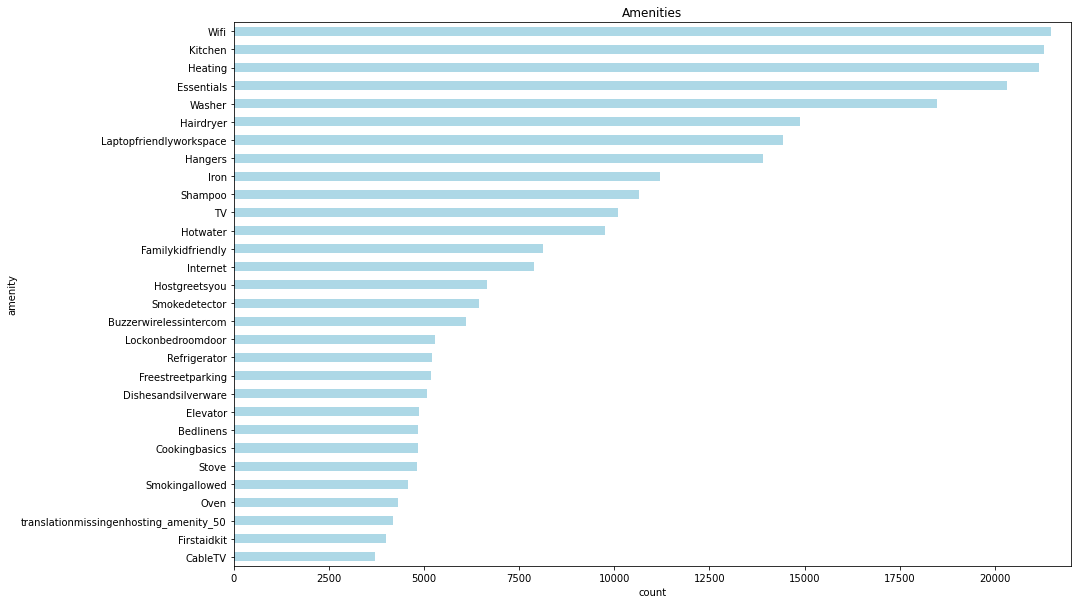

In [71]:
amenities_plot_df.head(30).sort_values(by = ['count'],ascending=True).plot(kind='barh' ,xlim = (0,22000),
                                                      figsize=(15,10), legend=False, color='lightblue',
                                                      title='Amenities')
plt.xlabel('count');

In [72]:
df2=df.copy()

In [73]:

df.loc[df['amenities'].str.contains('Essentials'), 'Essentials'] = 1
df.loc[df['amenities'].str.contains('Hair dryer'), 'Hairdryer'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly'), 'Familykidfriendly'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'Elevator'] = 1
df.loc[df['amenities'].str.contains('Internet'), 'Internet'] = 1
df.loc[df['amenities'].str.contains('Hot water'), 'Hotwater'] = 1
df.loc[df['amenities'].str.contains('Hangers'), 'Hangers'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'Hostgreetsyou'] = 1
df.loc[df['amenities'].str.contains('Cable TV'), 'CableTV'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'Smokingallowed'] = 1
df.loc[df['amenities'].str.contains('TV'), 'TV'] = 1
df.loc[df['amenities'].str.contains('Laptop friendly workspace'), 'Laptopfriendlyworkspace'] = 1
df.loc[df['amenities'].str.contains('Heating'), 'Heating'] = 1
df.loc[df['amenities'].str.contains('Free street parking'), 'Freestreetparking'] = 1





## Feature Engineering 2:  **host_verifications**

In [74]:
def host_verification(cols):
    possible_words = {}
    i = 0
    for col in cols:
        words = col.split()
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '' and wr not in possible_words:
                possible_words[wr] = i
                i += 1
    print (possible_words)
    l = len(possible_words)

    new_cols = np.zeros((cols.shape[0], l))
    for i, col in enumerate(cols):
        words = col.split()
        arr = np.zeros(l)
        for w in words:
            wr = re.sub(r'\W+', '', w)
            if wr != '':
                arr[possible_words[wr]] = 1
        new_cols[i] = arr
    return pd.DataFrame(new_cols,columns=list(possible_words.keys())).astype('int64')


In [75]:
host_verification_df = host_verification(df['host_verifications'])

{'email': 0, 'phone': 1, 'reviews': 2, 'facebook': 3, 'jumio': 4, 'government_id': 5, 'offline_government_id': 6, 'selfie': 7, 'identity_manual': 8, 'work_email': 9, 'manual_online': 10, 'google': 11, 'kba': 12, 'manual_offline': 13, 'zhima_selfie': 14, 'sesame': 15, 'sesame_offline': 16, 'sent_id': 17, 'weibo': 18, 'photographer': 19}


In [76]:
host_verification_plot_df=pd.melt(host_verification_df, value_name='count',var_name='platform',)
host_verification_plot_df=host_verification_plot_df.groupby('platform', as_index=True).agg({"count": "sum"}).sort_values(['count'],ascending =False)
host_verification_plot_df

,count
platform,
phone,22363
email,21484
reviews,18117
government_id,13041
jumio,12949
offline_government_id,6737
facebook,4752
selfie,3560
identity_manual,3444


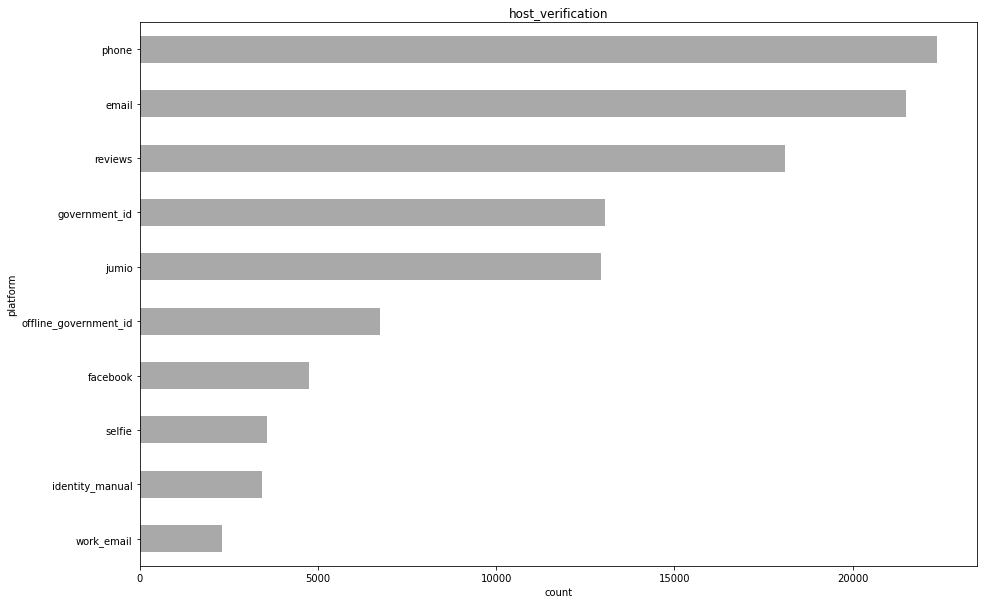

In [77]:
host_verification_plot_df.head(10).sort_values(by = ['count'],ascending=True).plot(kind='barh' ,
                                                      figsize=(15,10), legend=False, color='darkgrey',
                                                      title='host_verification')
plt.xlabel('count');

In [78]:
df.loc[df['host_verifications'].str.contains('reviews'), 'host_verification_by_reviews'] = 1
df.loc[df['host_verifications'].str.contains('facebook'), 'host_verification_by_facebook'] = 1
df.loc[df['host_verifications'].str.contains('selfie'), 'host_verification_by_selfie'] = 1
df.loc[df['host_verifications'].str.contains('email'), 'host_verification_by_email'] = 1
df.loc[df['host_verifications'].str.contains('government_id'), 'host_verification_by_government_id'] = 1

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 0 to 22551
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  22526 non-null  int64         
 1   host_since                          22526 non-null  datetime64[ns]
 2   security_deposit                    22526 non-null  int64         
 3   cleaning_fee                        22526 non-null  int64         
 4   extra_people                        22526 non-null  int64         
 5   price                               22526 non-null  int64         
 6   latitude                            22526 non-null  float64       
 7   longitude                           22526 non-null  float64       
 8   amenities                           22526 non-null  object        
 9   host_verifications                  22526 non-null  object        
 10  accommodates          

In [80]:
cols_to_replace_nulls = df.iloc[:,46:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].astype('int64')
df['amenities_number'] = df.amenities.apply(lambda s: len(str(s)[1:].split(',')))


df['host_verification_level'] = df.host_verifications.apply(lambda s: len(s.split(', ')))


In [81]:
for col in booleans:
  if col in df:
    df[col] = df[col].astype('int64')


In [82]:
df

,id,host_since,security_deposit,cleaning_fee,extra_people,price,latitude,longitude,amenities,host_verifications,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,calendar_updated,host_days_active,time_since_first_review,time_since_last_review,Essentials,Hairdryer,Familykidfriendly,Elevator,Internet,Hotwater,Hangers,Hostgreetsyou,CableTV,Smokingallowed,TV,Laptopfriendlyworkspace,Heating,Freestreetparking,host_verification_by_reviews,host_verification_by_facebook,host_verification_by_selfie,host_verification_by_email,host_verification_by_government_id,amenities_number,host_verification_level
0,13011494,2012-12-11,250,20,10,40,52.492309,13.427217,"{Wifi,Kitchen,""Free street parking"",""Buzzer/wi...","['email', 'phone', 'reviews']",1,1,1,1,1,4,30,0,0,0,0,8,95-100/100,10/10,10/10,10/10,10/10,9/10,10/10,2,0.50,unknown,0,0,Reuterstraße,Neukölln,0,Apartment,Private room,Real Bed,0,moderate,more then a month ago,2157,1-2 years,2-6 months,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,1,0,17,3
1,13012064,2016-05-13,0,0,0,98,52.540207,13.419285,"{Wifi,Kitchen,Washer,Essentials,""translation m...","['email', 'phone', 'reviews']",2,1,1,1,1,1,1125,0,0,0,0,1,95-100/100,10/10,0-8/10,10/10,10/10,10/10,10/10,1,0.03,unknown,0,0,Helmholtzplatz,Pankow,1,Other,Shared room,Real Bed,0,flexible,more then a month ago,908,2-3 years,1+ year,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,6,3
2,13013132,2016-05-13,0,25,20,45,52.534344,13.551447,"{TV,Wifi,Kitchen,""Free parking on premises"",""S...","['email', 'phone', 'facebook', 'reviews']",3,1,1,1,1,1,14,28,58,88,363,6,95-100/100,10/10,9/10,10/10,10/10,9/10,0-8/10,1,0.20,within a day,0,0,Marzahn-Süd,Marzahn - Hellersdorf,1,Apartment,Private room,Real Bed,0,strict_with_grace_period,4 weeks ago,908,2-3 years,2-8 weeks,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,16,4
3,13013744,2012-01-24,0,0,5,25,52.476278,13.435592,"{Internet,Wifi,Kitchen,Heating,Washer,Essentia...","['email', 'phone', 'reviews', 'jumio', 'govern...",2,1,1,1,1,1,1125,0,0,0,0,1,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,1,0.03,unknown,0,1,Neuköllner Mitte/Zentrum,Neukölln,1,Apartment,Private room,Real Bed,0,flexible,more then a month ago,2479,2-3 years,1+ year,1,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,10,5
4,13017018,2014-10-27,0,80,40,123,52.491799,13.431637,"{Internet,Wifi,Kitchen,""Pets allowed"",Gym,Cat(...","['email', 'phone', 'reviews', 'jumio', 'offlin...",6,1,3,3,1,3,50,0,2,2,2,13,80-94/100,9/10,9/10,9/10,10/10,10/10,9/10,1,0.43,unknown,0,0,Reuterstraße,Neukölln,1,Apartment,Entire home/apt,Real Bed,1,moderate,3 weeks ago,1472,2-3 years,2-8 weeks,1,1,1,0,1,0,1,0,0,0,0,1,1,0,1,0,1,1,1,20,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22547,12998742,2016-02-02,0,0,0,30,52.544092,13.364352,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Buzzer/w...","['email', 'phone', 'reviews', 'jumio', 'offlin...",1,1,1,2,1,3,1125,0,0,0,0,1,95-100/100,0-8/10,10/10,10/10,10/10,0-8/10,10/10,1,0.03,unknown,0,0,Brunnenstr. Nord,Mitte,0,Apartment,Entire home/apt,Real Bed,1,flexible,more then a month ago,1009,2-3 years,1+ year,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,8,8
22548,12999578,2015-06-08,0,0,0,16,52.559387,13.387173,"{Wifi,Kitchen,""Smoking allowed"",""Buzzer/wirele...","['phone', 'reviews']",1,1,1,1,1,3,1125,0,0,0,0,5,95-100/100,10/10,10/10

## Feature Engineering 3:  **Distance to Centroid of Berlin**

In [83]:
def distance_to_mid(latitude, longitude):
    berlin_city_centre = (52.52200654539689, 13.413257592827497)
    accommodation = (latitude, longitude)
    return great_circle(berlin_city_centre, accommodation).km


In [84]:
df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [85]:
df.drop(['latitude','longitude','amenities','host_verifications','neighbourhood_cleansed','neighbourhood_group_cleansed'], axis=1, inplace=True)


In [86]:
df = df.set_index('id')
df.sort_index()

,host_since,security_deposit,cleaning_fee,extra_people,price,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_time,host_is_superhost,host_identity_verified,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,calendar_updated,host_days_active,time_since_first_review,time_since_last_review,Essentials,Hairdryer,Familykidfriendly,Elevator,Internet,Hotwater,Hangers,Hostgreetsyou,CableTV,Smokingallowed,TV,Laptopfriendlyworkspace,Heating,Freestreetparking,host_verification_by_reviews,host_verification_by_facebook,host_verification_by_selfie,host_verification_by_email,host_verification_by_government_id,amenities_number,host_verification_level,distance
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,2008-08-18,200,30,28,60,3,1,1,2,1,4,1125,0,21,51,141,118,80-94/100,10/10,9/10,10/10,10/10,10/10,9/10,4,3.76,within an hour,1,1,0,Other,Entire home/apt,Real Bed,0,strict_with_grace_period,more then a month ago,3733,2-3 years,0-2 weeks,1,1,1,0,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,29,6,1.570175
2695,2008-09-16,0,0,0,17,2,1,1,1,1,2,40,0,0,0,0,6,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,1,1.42,unknown,0,1,1,Apartment,Private room,Real Bed,0,flexible,more then a month ago,3704,0-6 months,2-8 weeks,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,10,5,3.005595
3176,2008-10-19,200,50,20,90,4,1,1,2,2,62,1125,0,0,0,220,143,80-94/100,9/10,9/10,9/10,9/10,10/10,9/10,1,1.25,within a day,0,1,1,Apartment,Entire home/apt,Real Bed,1,strict_with_grace_period,This week,3671,4+ years,1+ year,1,1,1,0,1,0,1,0,0,0,0,1,1,0,1,1,0,1,1,19,7,1.473666
3309,2008-11-07,250,30,18,26,2,1,1,1,1,5,360,0,0,22,297,25,80-94/100,9/10,9/10,9/10,10/10,9/10,9/10,1,0.39,unknown,0,1,1,Apartment,Private room,Pull-out Sofa,0,strict_with_grace_period,4 weeks ago,3652,4+ years,2-6 months,1,1,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,29,6,5.049754
7071,2009-05-16,0,0,24,42,2,1,1,2,1,2,10,15,26,26,26,197,95-100/100,10/10,10/10,10/10,10/10,10/10,9/10,1,1.75,within an hour,1,1,1,Apartment,Private room,Real Bed,0,moderate,This week,3462,4+ years,0-2 weeks,1,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,1,13,5,2.355124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856708,2016-08-02,0,0,0,60,2,1,1,1,1,2,1125,4,9,39,314,0,nan,nan,nan,nan,nan,nan,nan,1,NaN,unknown,0,0,1,Apartment,Entire home/apt,Real Bed,0,flexible,today,827,nan,nan,1,1,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,1,0,9,3,1.567425
29857108,2016-04-17,0,0,10,20,6,1,1,4,1,1,14,25,48,78,78,0,nan,nan,nan,nan,nan,nan,nan,6,NaN,within an hour,0,0,1,Apartment,Shared room,Real Bed,1,flexible,today,934,nan,nan,1,1,0,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,1,20,5,5.626313
29864272,2012-08-03,0,0,0,85,2,1,1,1,1,3,30,3,15,15,15,0,nan,nan,nan,nan,nan,nan,nan,2,NaN,unknown,0,1,0,Apartment,Entire home/apt,Real Bed,0,flexible,today,2287,nan,nan,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,8,5,1.092279


 ## Feature Engineering 4: **Reviews**

In [87]:
!pip install vaderSentiment
!pip install langdetect

     |████████████████████████████████| 125 kB 11.2 MB/s 
     |████████████████████████████████| 981 kB 12.6 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=c88242eae826251f7a23eed17eb067a85a6bd2bdd920eaadd9e2509c19390f7b
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [88]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [89]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
analyser = SentimentIntensityAnalyzer()

In [90]:
drive.mount('/content/gdrive/')
path = '/content/gdrive/MyDrive/AirBnb/df_r.csv'
df_r = pd.read_csv(path)

Mounted at /content/gdrive/


In [91]:

#df_r = pd.read_sql(query3, cnxn)
df_r.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,28016965,325900430,2018-09-21,36327811,Laura,Marie is a great host and her flat is super ni...
1,28016965,329641138,2018-09-29,994403,Paul,Marie's place is lovely and in a great locatio...
2,28016965,336479900,2018-10-14,7837590,Raoul,"Marie ist eine super Gastgeberin, unkomplizier..."
3,28016965,337989256,2018-10-18,98206919,Katrin,Die Wohnung ist super-schön & gemütlich. Auch ...
4,28018592,332337497,2018-10-05,29443153,Kelly,This apartment is amazing. Perfectly situated ...


In [92]:
df_r.comments.isnull().sum()

593

In [93]:
df_r.dropna(subset=['comments'], how='any', axis=0, inplace=True)

In [94]:

df_r.comments.isnull().sum()

0

In [95]:
%%time
def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

#df_r['lang'] = df_r['comments'].apply(det)
#dfrr['lang'] = dfrr['comments'].apply(det)

CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 45.1 µs


In [96]:
%%time
#df_r['polarity']=df_r['comments'].apply(lambda x:analyser.polarity_scores(x)['compound'] )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


In [97]:
drive.mount('/content/gdrive/')



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [98]:
path2 =  '/content/gdrive/MyDrive/AirBnb/df_r_after_sentiment.csv'
a=pd.read_csv(path2)
df_r=a


In [99]:
df_r

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity,lang
0,28016965,325900430,2018-09-21,36327811,Laura,Marie is a great host and her flat is super ni...,0.9079,en
1,28016965,329641138,2018-09-29,994403,Paul,Marie's place is lovely and in a great locatio...,0.9391,en
2,28016965,336479900,2018-10-14,7837590,Raoul,"Marie ist eine super Gastgeberin, unkomplizier...",-0.5994,de
3,28016965,337989256,2018-10-18,98206919,Katrin,Die Wohnung ist super-schön & gemütlich. Auch ...,-0.9184,de
4,28018592,332337497,2018-10-05,29443153,Kelly,This apartment is amazing. Perfectly situated ...,0.9450,en
...,...,...,...,...,...,...,...,...
401379,28009243,324914035,2018-09-18,114849831,Analety,"Nice place to stay in!! \nClose to metro, supe...",0.6083,en
401380,28016965,319454974,2018-09-06,1621980,Stav,"Marie was a great host, everything is as expec...",0.9153,en
401381,28016965,320262645,2018-09-08,44683108,Yannik,"Eines der besten AirBnB-Erlebnisse, die ich bi...",-0.9800,de
401382,28016965,322782376,2018-09-14,144591259,Celia,Wunderschöne Wohnung mit super freundlicher Ga...,0.0000,de


In [100]:
df_rev = df_r.groupby('listing_id', as_index=True).agg({"polarity": "mean"}).sort_values(['listing_id'],ascending =True)
df_rev


,polarity
listing_id,
2015,0.481131
2695,0.911833
3176,0.785511
3309,0.433232
7071,0.705238
...,...
29772631,0.000000
29784461,0.000000
29792124,0.000000


In [101]:
df_rev['sentiment'] = 0
df_rev.loc[df_rev['polarity'] < -0.05, 'sentiment'] = -1
df_rev.loc[df_rev['polarity'] > 0.05, 'sentiment'] = 1

In [102]:
df_rev2=df_rev.copy()

In [103]:
df_wr = df.merge(df_rev,how='left',left_index=True, right_index=True).sort_values(['id'],ascending =True)

In [104]:
df_wr['polarity'].fillna(df_wr['polarity'].median(), inplace=True)

In [105]:
df_wr.loc[(df_wr.sentiment.isna()) & (df_wr.polarity > 0.05 ),'sentiment'] = 1

In [106]:
df_wr.loc[(df_wr.sentiment.isna()) & (df_wr.polarity < -0.05 ),'sentiment'] = -1 

In [107]:
df_wr['sentiment'].describe()

count    22526.000000
mean         0.853813
std          0.464290
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

In [108]:
#df_wr.drop('first_review', axis=1, inplace=True)
df_wr.drop('host_since', axis=1, inplace=True)
df_wr.drop([ 'reviews_per_month'], axis=1, inplace=True)

In [109]:
df=df_wr.copy()

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 2015 to 29867352
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   security_deposit                    22526 non-null  int64  
 1   cleaning_fee                        22526 non-null  int64  
 2   extra_people                        22526 non-null  int64  
 3   price                               22526 non-null  int64  
 4   accommodates                        22526 non-null  int64  
 5   bathrooms                           22526 non-null  int64  
 6   bedrooms                            22526 non-null  int64  
 7   beds                                22526 non-null  int64  
 8   guests_included                     22526 non-null  int64  
 9   minimum_nights                      22526 non-null  int64  
 10  maximum_nights                      22526 non-null  int64  
 11  availability_30                    

(None,)

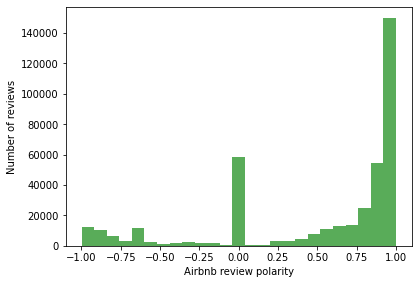

In [111]:
#hist of original df_r - all lang
plt.hist(df_r.polarity, bins=25, color='g', alpha=0.65)
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png') , 


In [112]:

df_r.lang.value_counts(normalize=True,dropna=False)

# Replacing rest categories of more than a month
df_r.loc[~df_r.lang.isin(['en']), 'lang'] = 'Other'

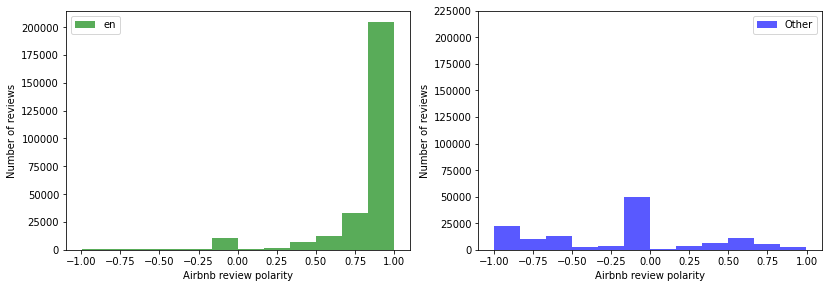

In [113]:
## different between en reviews to others

fig, ax = plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
plt1 = plt.hist(df_r['polarity'].loc[df_r['lang'] == 'en'], color='g',bins=12, alpha=0.65)
plt1 = plt.xlabel('Airbnb review polarity')
plt1 = plt.ylabel('Number of reviews')
plt1 = plt.legend([ 'en'])
plt.subplot(122)
plt2 = plt.hist(df_r['polarity'].loc[df_r['lang'] == 'Other'], color='b',bins=12, alpha=0.65)
#plt.legend([ 'Other'])
#plt1 = plt.xlabel('Airbnb review polarity')
plt2 = plt.ylabel('Number of reviews')
plt2 = plt.xlabel('Airbnb review polarity')
plt2 = plt.legend([ 'Other'])
#plt1 = plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=1.2, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')
plt.ylim([0, 225000])
plt.show()


##outliers



In [114]:
df_cont = df.describe().T
df_cont['iqr_max'] = df_cont['75%'] + 1.5 * (df_cont['75%'] - df_cont['25%'])
df_cont['iqr_min'] = df_cont['75%'] - 1.5 * (df_cont['75%'] - df_cont['25%'])
df_cont['Exceeds_low_limit'] = df_cont['min'].le(df_cont['iqr_min'])
df_cont['Exceeds_top_limit'] = df_cont['max'].gt(df_cont['iqr_max'])
                                     
df_cont[['Exceeds_low_limit','iqr_min','min','50%','mean','max','iqr_max','Exceeds_top_limit']]

,Exceeds_low_limit,iqr_min,min,50%,mean,max,iqr_max,Exceeds_top_limit
security_deposit,False,-75.000000,0.000000,0.000000,118.190136,4.280000e+03,375.000000,True
cleaning_fee,False,-15.000000,0.000000,10.000000,18.172556,4.500000e+02,75.000000,True
extra_people,False,-7.500000,0.000000,5.000000,8.260677,2.500000e+02,37.500000,True
price,True,10.000000,0.000000,45.000000,66.771020,8.600000e+03,130.000000,True
accommodates,True,1.500000,1.000000,2.000000,2.637530,1.600000e+01,4.500000,True
bathrooms,True,1.000000,0.000000,1.000000,1.064858,8.000000e+00,1.000000,True
bedrooms,True,1.000000,1.000000,1.000000,1.226583,1.200000e+01,1.000000,True
beds,False,0.500000,1.000000,1.000000,1.620749,2.200000e+01,3.500000,True
guests_included,True,1.000000,1.000000,1.000000,1.332194,1.600000e+01,1.000000,True
minimum_nights,True,1.000000,1.000000,2.000000,7.159061,5.000000e+03,7.000000,True


# 4.Modeling

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22526 entries, 2015 to 29867352
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   security_deposit                    22526 non-null  int64  
 1   cleaning_fee                        22526 non-null  int64  
 2   extra_people                        22526 non-null  int64  
 3   price                               22526 non-null  int64  
 4   accommodates                        22526 non-null  int64  
 5   bathrooms                           22526 non-null  int64  
 6   bedrooms                            22526 non-null  int64  
 7   beds                                22526 non-null  int64  
 8   guests_included                     22526 non-null  int64  
 9   minimum_nights                      22526 non-null  int64  
 10  maximum_nights                      22526 non-null  int64  
 11  availability_30                    

In [116]:
for col in  df.select_dtypes(include='object'):
  df[col] = df[col].astype('category')


In [117]:
#a=list(df.columns[df.columns.str.startswith('host')])

In [118]:
#plt.figure(figsize = (20,20))
#sns.heatmap(df.corr().abs())


In [119]:
#df=df.drop(['beds','bedrooms','guests_included','availability_60','polarity','availability_90', ],axis=1)

In [120]:
target = df[["price"]]
df_features=df.drop(["price"], axis=1)

In [121]:
df_numerical = df_features.select_dtypes(include=['int64','float64'])
cor_matrix = df_numerical.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
df_numerical=df_numerical.drop(to_drop,axis=1)

In [122]:
df_categorical = df_features.select_dtypes(include='category')
df_categorical_d = pd.get_dummies(df_categorical)
cor_matrix = df_categorical_d.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop2 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
df_categorical_d=df_categorical_d.drop(to_drop2,axis=1)

In [123]:

df_numerical_cols = df_numerical.columns.tolist()
df_categorical_cols = df_categorical.columns.tolist()
df_categorical_d_cols = df_categorical_d.columns.tolist()

print(len(df_numerical_cols),len(df_categorical_d_cols)) 

40 54


##Feature Selection

In [ ]:
### Feature Selection
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
varSel= pd.DataFrame({'Variable': df_numerical_cols})                                   

lassomod = Lasso(alpha=0.01).fit(df_numerical,target)

model = SelectFromModel(lassomod, prefit=True)
varSel['Lasso'] = model.get_support().astype('int64')
varSel





In [ ]:
svmmod = LinearSVC(C=0.01, penalty="l1",dual=False).fit(df_numerical,target)
model = SelectFromModel(svmmod, prefit=True)
varSel['SVM'] = model.get_support().astype('int64')
varSel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
rfmod = RandomForestClassifier().fit(df_numerical,target)

model = SelectFromModel(rfmod, prefit=True)
varSel['RandomForest'] = model.get_support().astype('int64')
varSel

In [ ]:
varSel

In [ ]:
%%time
gbmod = GradientBoostingClassifier().fit(df_numerical,target)
model = SelectFromModel(gbmod, prefit=True)
varSel['GradientBoost'] = model.get_support().astype('int64')
varSel


In [124]:
path = '/content/gdrive/MyDrive/AirBnb/varSel.csv'
varSel = pd.read_csv(path)

In [258]:
varSel['Sum'] =  np.sum(varSel,axis=1)
varSel

#features=df[varSel[varSel['Sum']>=3].Variable]

,Variable,Lasso,SVM,RandomForest,GradientBoost,Sum
0,security_deposit,1,1,1,0,6
1,cleaning_fee,1,1,1,1,8
2,extra_people,1,1,1,1,8
3,accommodates,1,1,1,0,6
4,bathrooms,1,1,0,0,4
5,bedrooms,1,1,0,0,4
6,guests_included,1,1,0,1,6
7,minimum_nights,1,1,1,0,6
8,maximum_nights,0,1,1,0,4
9,availability_30,1,1,0,0,4


In [125]:
varSel


,Variable,Lasso,SVM,RandomForest,GradientBoost,Sum
0,security_deposit,1,1,1,0,3
1,cleaning_fee,1,1,1,1,4
2,extra_people,1,1,1,1,4
3,accommodates,1,1,1,0,3
4,bathrooms,1,1,0,0,2
5,bedrooms,1,1,0,0,2
6,guests_included,1,1,0,1,3
7,minimum_nights,1,1,1,0,3
8,maximum_nights,0,1,1,0,2
9,availability_30,1,1,0,0,2


In [126]:
varSel[varSel['Sum']>=3]

,Variable,Lasso,SVM,RandomForest,GradientBoost,Sum
0,security_deposit,1,1,1,0,3
1,cleaning_fee,1,1,1,1,4
2,extra_people,1,1,1,1,4
3,accommodates,1,1,1,0,3
6,guests_included,1,1,0,1,3
7,minimum_nights,1,1,1,0,3
10,availability_365,1,1,1,1,4
11,number_of_reviews,1,1,1,1,4
12,calculated_host_listings_count,1,1,0,1,3
17,host_days_active,1,1,1,1,4


In [127]:
df_numerical_new=df_numerical[varSel[varSel['Sum']>=3].Variable]

In [128]:
Features = pd.concat([df_numerical_new, df_categorical_d ], axis=1)
Features_cols =Features.columns.tolist()

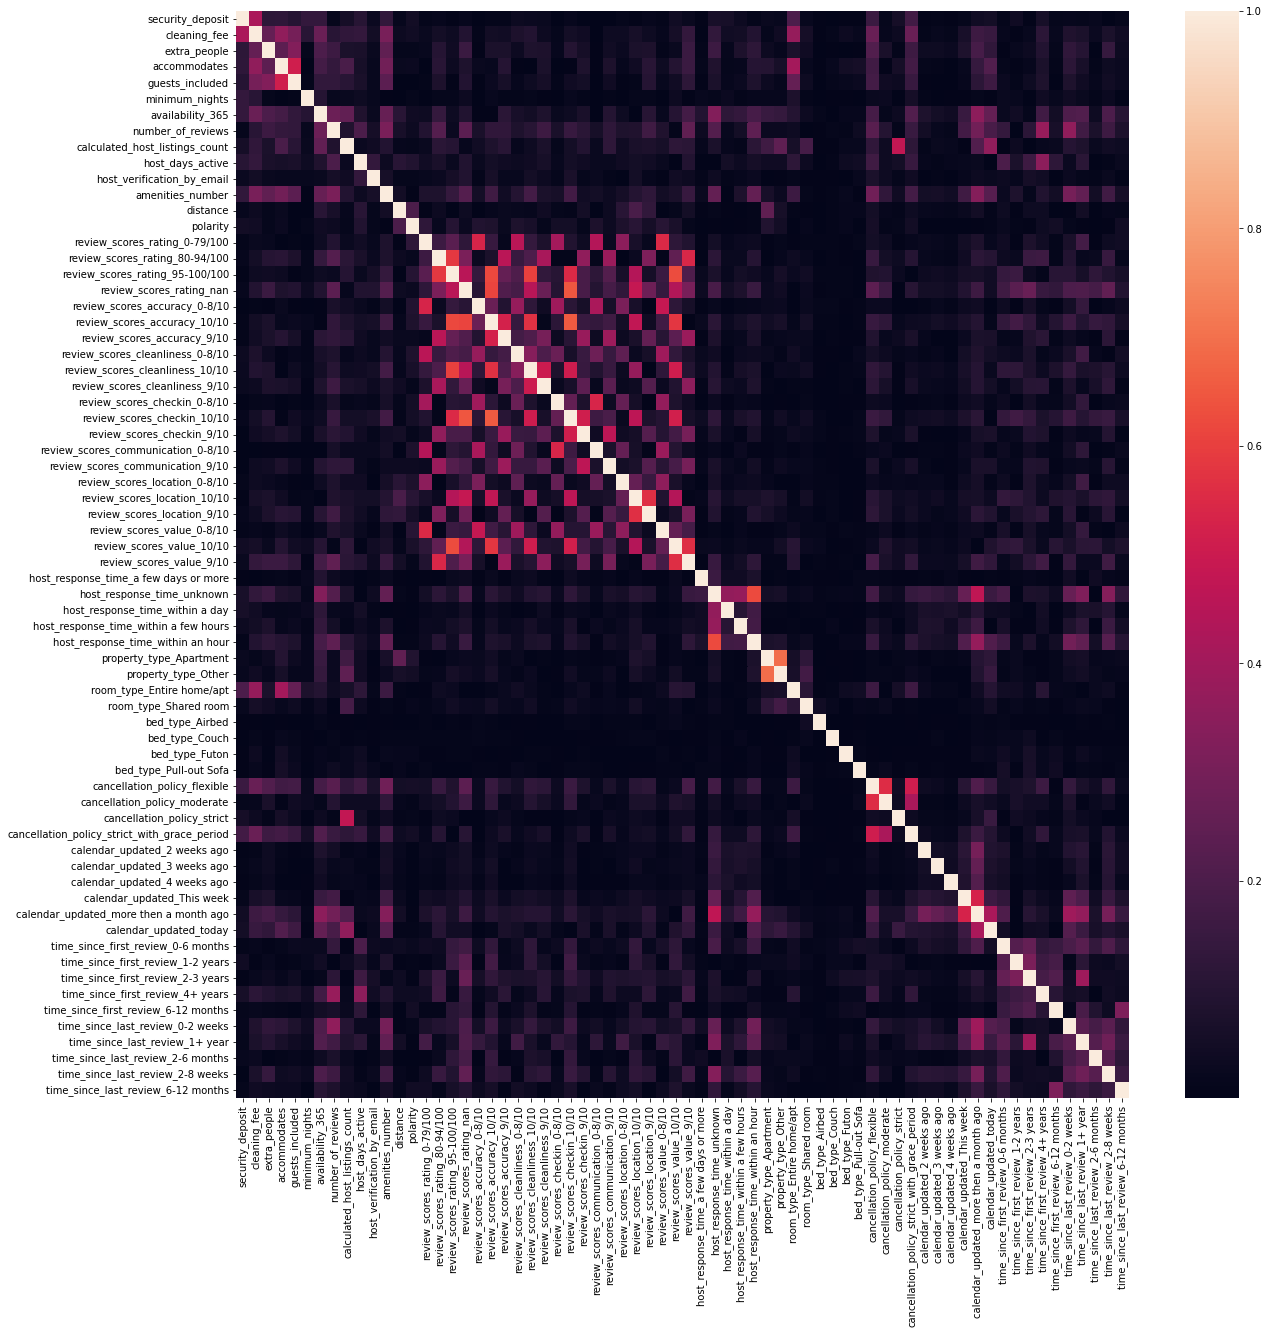

In [129]:
plt.figure(figsize = (20,20))
sns.heatmap(Features.corr().abs())


In [130]:
pip install xgboost

In [131]:
Features

,security_deposit,cleaning_fee,extra_people,accommodates,guests_included,minimum_nights,availability_365,number_of_reviews,calculated_host_listings_count,host_days_active,host_verification_by_email,amenities_number,distance,polarity,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_communication_0-8/10,review_scores_communication_9/10,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,property_type_Apartment,property_type_Other,room_type_Entire home/apt,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_with_grace_period,calendar_updated_2 weeks ago,calendar_updated_3 weeks ago,calendar_updated_4 weeks ago,calendar_updated_This week,calendar_updated_more then a month ago,calendar_updated_today,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_0-2 weeks,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,200,30,28,3,1,4,141,118,4,3733,1,29,1.570175,0.481131,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
2695,0,0,0,2,1,2,0,6,1,3704,1,10,3.005595,0.911833,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3176,200,50,20,4,2,62,220,143,1,3671,1,19,1.473666,0.785511,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
3309,250,30,18,2,1,5,297,25,1,3652,1,29,5.049754,0.433232,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
7071,0,0,24,2,1,2,26,197,1,3462,1,13,2.355124,0.705238,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856708,0,0,0,2,1,2,314,0,1,827,1,9,1.567425,0.529180,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
29857108,0,0,10,6,1,1,78,0,6,934,1,20,5.626313,0.529180,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
29864272,0,0,0,2,1,3,15,0,2,2287,1,8,1.092279,0.529180,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


## Training an XGBoost Regressor 
*italicised text*

In [132]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


In [133]:
# split our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, target, test_size=0.2)


In [134]:
booster = xgb.XGBRegressor()


In [135]:
# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}


In [136]:
# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3)


In [ ]:
# train the tuned random forest

booster_grid_search.fit(X_train, y_train)


In [138]:
# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)


{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [151]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)



In [152]:
# train
booster.fit(X_train, y_train)


[04:10:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=4,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [153]:
# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")


RMSE: 188.9985
r2: 0.4949


## Cross Validation

In [ ]:
# 4.4. Cross Validation

In [154]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

params = {'colsample_bytree':0.6, 'gamma':0.0, 'learning_rate':0.1, 'max_depth':6}


In [155]:

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=4,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)



In [156]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,190.262047,9.856679,188.955490,32.521579
1,175.287892,8.756689,176.445347,30.474966
2,162.149094,7.554064,164.674362,28.033181
3,150.042175,6.612943,153.490906,25.149757
4,139.253624,6.119308,144.087908,22.566310
5,130.119497,6.173548,135.744377,21.537438
6,121.585774,5.555283,128.990458,21.972658
7,113.916685,5.120037,122.780193,20.814092
8,106.734327,4.653096,117.905220,21.648310
9,100.677134,4.431126,113.143837,21.191896


In [157]:
cv_results.head()



,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,190.262047,9.856679,188.955490,32.521579
1,175.287892,8.756689,176.445347,30.474966
2,162.149094,7.554064,164.674362,28.033181
3,150.042175,6.612943,153.490906,25.149757
4,139.253624,6.119308,144.087908,22.566310


In [158]:
cv_results.tail()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
38,49.620568,4.824329,86.367544,24.230830
39,49.046806,4.483603,86.414793,24.176408
40,48.524258,4.481382,86.333450,24.206457
41,47.956347,4.663492,86.293521,24.085389
42,47.466134,4.339156,86.217661,24.088343


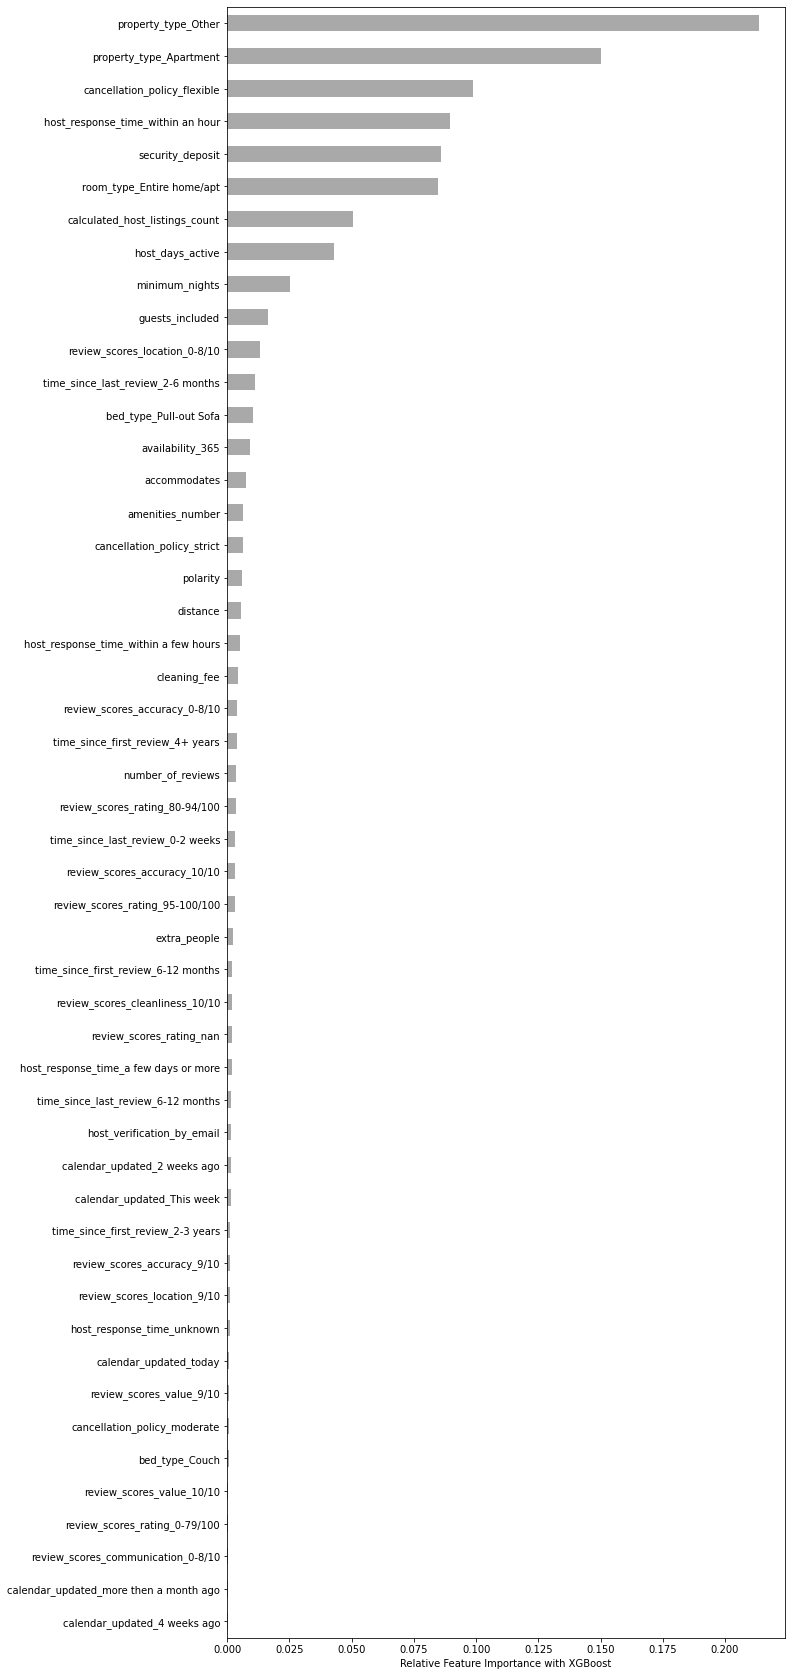

In [159]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=Features.columns)
feat_importances.nlargest(50).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,30))
plt.xlabel('Relative Feature Importance with XGBoost');

In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
# wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?

In [ ]:
# in the prompt click - yes

In [ ]:
# as you see the ram increase from 12GB to 25GB

In [ ]:
#thanks for watching, keep learning 

**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

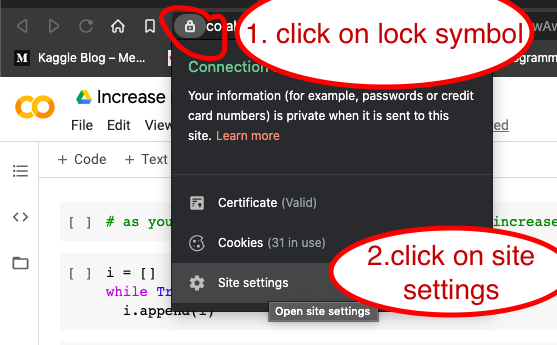

In [ ]:
#step-1

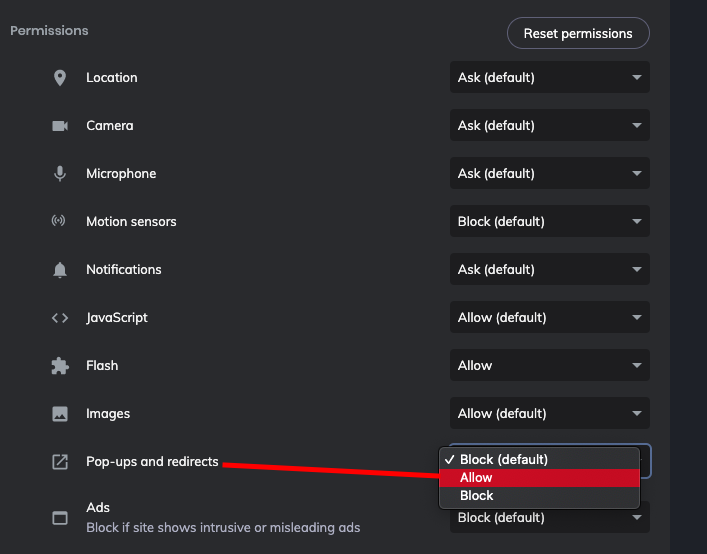

In [ ]:
#step-2